# Method -2 Notebook 2 - loading the models and performing evaluations

This is almost the same notebook as Method 2 model 1, but in this notebook the saved model's were directly loaded and some other evalutions were analyzed.

Excecuting it here in jupyter will give errors, since this file was executed in google collab

## Pycaret

#### The modeling process greatly benefited from the role of PyCaret. This tool proved to be a significant time-saver by automating many machine-learning aspects. It involved setting up the appropriate environments, model selection, and, most importantly, hyperparameter tuning. A significant reduction in manual intervention made the whole process much more reliable.

### Installing required pycaret packages

In [ ]:
pip install --upgrade pycaret


In [ ]:
pip install --upgrade pycaret[analysis]


### Importing pandas and reading the dataset

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('train_upd_dum.csv')

### Importing all necessary packages 

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
df.shape

(27674, 88)

In [ ]:
df.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'breast_cancer_diagnosis_year', 'metastatic_cancer_diagnosis_code',
       'metastatic_first_treatment', 'metastatic_first_treatment_type',
       'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'region', 'division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_5

### Preproceesing the data

The preprocessor function provided performs data cleaning and transformation on a DataFrame. It addresses missing values, drops certain columns, changes data types, and encodes categorical variables. In missing values for 'region' and 'division', 'Others' is imputed. 'payer_type' has 'UNINSURED' for missing values. It removes several columns such as those associated with the race of patients, BMI, and treatment of metastatic cancer. In 'self_employed' and 'farmer', their medians are imputed whenever there is a missing value. If certain socioeconomic features contain any null, the entire row is removed. For various columns, DataFrame has changed to 'category' data type to make processing more efficient. Additionally, 'payer_type' is one-hot encoded, and various categorical columns involving the diagnosis and treatment of cancer are frequency-encoded, i.e., they are replaced by their distribution based on frequency. Original categorical columns and the 'patient_gender' are finally removed after being encoded, and this prepares clean data for use in analysis.

In [ ]:
def preprocessor(df):
  # Fill null values in the 'region' and'division' column with 'Others'
  df['region'] = df['region'].fillna('Others')
  df['division'] = df['division'].fillna('Others')
  # Fill null values in the 'payer_type' column with 'UNINSURED'
  df['payer_type'] = df['payer_type'].fillna('UNINSURED')
  df = df.drop(['patient_race', 'bmi', 'metastatic_first_treatment_type', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1)
  df['self_employed'].fillna(df['self_employed'].median(), inplace=True)
  df['farmer'].fillna(df['farmer'].median(), inplace=True)
  df.dropna(subset=['family_size', 'family_dual_income', 'income_household_median','home_ownership', 'home_value', 'rent_median','rent_burden', 'poverty', 'limited_english'], inplace=True)
  df['patient_gender'] = df['patient_gender'].astype('category')
  df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].astype('category')
  df['breast_cancer_diagnosis_desc'] = df['breast_cancer_diagnosis_desc'].astype('category')
  df['metastatic_cancer_diagnosis_code'] = df['metastatic_cancer_diagnosis_code'].astype('category')
  df['metastatic_first_treatment'] = df['metastatic_first_treatment'].astype('category')
  df['region'] = df['region'].astype('category')
  df['division'] = df['division'].astype('category')
  payer_type_column = df[['payer_type']]

  # Perform one-hot encoding
  encoded_payer_type = pd.get_dummies(payer_type_column, prefix='payer_type', dtype=int)

  # Concatenate the encoded DataFrame with the original DataFrame
  df = pd.concat([df.drop(columns=['payer_type']), encoded_payer_type], axis=1)

  # Assuming df is your DataFrame containing the data

  # List of categorical columns to perform frequency encoding
  categorical_columns = ['breast_cancer_diagnosis_code','metastatic_cancer_diagnosis_code', 'metastatic_first_treatment']

  # Perform frequency encoding for each categorical column
  for col in categorical_columns:
      # Calculate the frequency of each category
      frequency_map = df[col].value_counts(normalize=True)
      # Replace each category with its frequency
      df[col + '_frequency_encoded'] = df[col].map(frequency_map)

  # Drop the original categorical columns
  df.drop(columns=categorical_columns, inplace=True)
  df.drop('patient_gender', inplace=True, axis=1)
  print(len(df.columns))
  return df


# Data Modelling

In [ ]:
df['patient_zip3'].unique()

array([917, 451, 773, 928, 112, 462, 877, 356, 330, 900, 906, 797, 775,
       983, 245, 600, 787, 190, 254, 194, 644, 283, 297, 913, 925, 234,
       314, 211, 708, 442, 982, 946, 427, 301, 481, 125, 723, 193, 931,
       776, 133, 754, 923, 605, 902, 436, 553, 346, 169, 485, 122, 804,
       207, 567, 378, 142, 291, 959, 853, 606, 483, 891, 237, 920, 711,
       446, 617, 770, 953, 562, 850, 768, 337, 304, 774, 945, 145,  79,
       750, 915, 778,  30, 785, 280, 235, 919, 950, 100, 631, 103,  70,
       171, 441, 751, 981, 974,  86, 272, 322, 174, 922, 327, 486, 402,
       782, 290, 727, 752, 296, 554, 300, 151, 386, 640, 707, 406,  32,
       471, 704, 794, 612, 910, 115, 912, 466, 460, 231, 113, 836, 316,
       119, 482,  67, 475, 627, 221, 934, 105, 980, 450, 930, 452, 217,
       461, 405,  43, 388, 453, 150, 921, 779, 760, 416, 298, 852, 210,
       927, 121, 444, 531, 331, 800,  68, 120, 309, 560, 857, 831, 914,
        71, 522, 463, 410, 731, 294, 933, 326, 535, 480, 180, 79

In [ ]:
train=preprocessor(df)

85


In [ ]:
len(train.columns)

85

In [ ]:
import pickle


In [ ]:
pip install pycaret

### Importing pycaret

In [ ]:
# Load your pre-trained models
import pycaret
from pycaret.regression import load_model as l_m
from pycaret.classification import load_model


### Training of Model 1- classifier

This classifier helps to predict whether the treatment_pd(target variable) would come under less than 276 days or greater than 276 days. This is useful as it serves as a preliminary step for further analysis.

#### Categorizing Treatment Periods into Binary Buckets in a DataFrame

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
# Create a new column 'bucket_365' based on the condition
train['bucket_276'] = train['treatment_pd'].apply(lambda x: 0 if x < 276 else 1)

# If 'bucket_365' needs to be a categorical variable (factor)
train['bucket_276'] = train['bucket_276'].astype('category')

# Display the DataFrame
print(df)


       patient_id patient_race          payer_type patient_state  \
0          994155        Asian          COMMERCIAL            CA   
1          154389          NaN  MEDICARE ADVANTAGE            OH   
2          387343          NaN          COMMERCIAL            TX   
3          921275     Hispanic            MEDICAID            CA   
4          803454          NaN          COMMERCIAL            NY   
...           ...          ...                 ...           ...   
27669      728161          NaN          COMMERCIAL            MO   
27670      203896          NaN          COMMERCIAL            IN   
27671      740115     Hispanic            MEDICAID            TX   
27672      122759          NaN          COMMERCIAL            AZ   
27673      849565        Black           UNINSURED            CA   

       patient_zip3  patient_age patient_gender    bmi  \
0               917           46              F  27.00   
1               451           63              F    NaN   
2        

In [ ]:
len(train.columns)

86

#### Preparing Data for Model Training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Prepare your data
X = train.drop(columns=['bucket_276'])
y = train['bucket_276']

##### An automated machine learning library called PyCaret was used to perform the classification task. The problem was to predict whether a patient's treatment period was shorter or longer than 276 days. The dataset was preprocessed and divided into features and the target. The target was converted to an integer for the sake of algorithmic compatibility. 

The classification module of PyCaret was then "initialized" (that is, set up to perform a run of the algorithm) with this dataset, which now had 98 features. The 10-fold cross-validation approach was employed to get a stable estimate of how well the algorithm would work on new, unseen data. And, the whole thing was run with GPU acceleration to speed up computing time.


In [ ]:
from pycaret.classification import ClassificationExperiment
train['bucket_276'] = train['bucket_276'].astype('int')
data=train.drop('treatment_pd', axis=1)
print(len(data.columns))
s = ClassificationExperiment()
s.setup(data, target = 'bucket_276', session_id = 123, use_gpu=True)

85
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset m

,Description,Value
0,Session id,123
1,Target,bucket_276
2,Target type,Binary
3,Original data shape,"(27671, 85)"
4,Transformed data shape,"(27671, 98)"
5,Transformed train set shape,"(19369, 98)"
6,Transformed test set shape,"(8302, 98)"
7,Numeric features,80
8,Categorical features,4
9,Rows with missing values,0.3%


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

In [ ]:
from pycaret.classification import ClassificationExperiment
train['bucket_276'] = train['bucket_276'].astype('int')
data=train.drop(['treatment_pd'], axis=1)
print(len(data.columns))
s1 = ClassificationExperiment()
s1.setup(data=data.drop(['geospatial_category_0',
       'geospatial_category_1', 'geospatial_category_2',
       'geospatial_category_3', 'geospatial_category_4'], axis=1), target = 'bucket_276', session_id = 123, use_gpu=True)

85
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset m

,Description,Value
0,Session id,123
1,Target,bucket_276
2,Target type,Binary
3,Original data shape,"(27671, 80)"
4,Transformed data shape,"(27671, 93)"
5,Transformed train set shape,"(19369, 93)"
6,Transformed test set shape,"(8302, 93)"
7,Numeric features,75
8,Categorical features,4
9,Rows with missing values,0.3%


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

### since we added geospatial data results at the end, the classifier was not really perfroming well, so we instead loaded our old best classifier pipeline to predict the treatment day greater or lesser than 276 or not. The below output interpretation is fro the old classifier model. Since I had the model saved, I directly loaded it. Running again the model will take time. I will add all my saved models when pushing on git. 

### Loading best saved classifier model that is light gradient boosting classifier

In [ ]:
best_class = s1.load_model('my_best_pipeline')


Transformation Pipeline and Model Successfully Loaded


### Preparing data for regression models

In [ ]:
df_greater_than_276= train[train['bucket_276']==1]
df_less_than_276= train[train['bucket_276']==0]

### Loading model2.1 and model 2.2 best regression models from training results

In [ ]:
from pycaret.datasets import get_data
data = df_greater_than_276[['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time',
       'veteran', 'payer_type_MEDICAID', 'payer_type_MEDICARE ADVANTAGE',
       'payer_type_UNINSURED',
       'breast_cancer_diagnosis_code_frequency_encoded',
       'metastatic_cancer_diagnosis_code_frequency_encoded',
       'metastatic_first_treatment_frequency_encoded','geospatial_category_0',
       'geospatial_category_1', 'geospatial_category_2',
       'geospatial_category_3', 'geospatial_category_4']]
data['treatment_pd']= df_greater_than_276['treatment_pd']

In [ ]:
# import RegressionExperiment and init the class
from pycaret.regression import RegressionExperiment
exp3 = RegressionExperiment()

In [ ]:
type(exp3)

pycaret.regression.oop.RegressionExperiment

In [ ]:
exp3.setup(data, target = 'treatment_pd', session_id = 123, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,123
1,Target,treatment_pd
2,Target type,Regression
3,Original data shape,"(3583, 62)"
4,Transformed data shape,"(3583, 62)"
5,Transformed train set shape,"(2508, 62)"
6,Transformed test set shape,"(1075, 62)"
7,Numeric features,61
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [ ]:

best_276_gt = exp3.load_model('model_g276_gs')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
from pycaret.datasets import get_data
data = df_less_than_276[['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time',
       'veteran', 'payer_type_MEDICAID', 'payer_type_MEDICARE ADVANTAGE',
       'payer_type_UNINSURED',
       'breast_cancer_diagnosis_code_frequency_encoded',
       'metastatic_cancer_diagnosis_code_frequency_encoded',
       'metastatic_first_treatment_frequency_encoded','geospatial_category_0',
       'geospatial_category_1', 'geospatial_category_2',
       'geospatial_category_3', 'geospatial_category_4']]
data['treatment_pd']= df_less_than_276['treatment_pd']

In [ ]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(data, target = 'treatment_pd', session_id = 124, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,124
1,Target,treatment_pd
2,Target type,Regression
3,Original data shape,"(24088, 62)"
4,Transformed data shape,"(24088, 62)"
5,Transformed train set shape,"(16861, 62)"
6,Transformed test set shape,"(7227, 62)"
7,Numeric features,61
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [ ]:
# import RegressionExperiment and init the class
from pycaret.regression import RegressionExperiment
exp4 = RegressionExperiment()

In [ ]:
type(exp4)

pycaret.regression.oop.RegressionExperiment

In [ ]:
exp4.setup(data, target = 'treatment_pd', session_id = 123, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,123
1,Target,treatment_pd
2,Target type,Regression
3,Original data shape,"(24088, 62)"
4,Transformed data shape,"(24088, 62)"
5,Transformed train set shape,"(16861, 62)"
6,Transformed test set shape,"(7227, 62)"
7,Numeric features,61
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [ ]:
# compare baseline models
best_276_lt = exp4.load_model('model_l276_gs')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
train.columns

Index(['patient_id', 'patient_state', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_year',
       'region', 'division', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female',
       'married', 'divorced', 'never_married', 'widowed', 'family_size',
       'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_figure',
       'income_individual_median', 'home_ownership', 'housing_units',
       'home_value', 'rent_median', 'rent_burden', 'edu

In [ ]:
data.columns

Index(['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'comm

In [ ]:
data.columns

Index(['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'comm

### Loading models and making prediction to combine all the hero models from Model 1, 2.1 and 2.2

The regression model’s predictions are merged to create a coherent and extensive treatment period prediction. This consolidates the different analyses of the two models and is essential to not only create a single-prediction framework but also to build predictive models with as much gain in their modeling efficiency as possible.
The unified prediction brings together all the analyses done in different parts of the treatment duration spectrum. It does more than that though; it also takes what was learned from those parts and aligns them. In other words, it makes sure all the knowledge from throughout the process participates in forming a single, correct treatment-duration estimate.


#### Classifier predictions on both seen and unseen data 

In [ ]:
from pycaret.classification import load_model, predict_model
loaded_modelsss = s.load_model('my_best_pipeline')
data=train.drop(['treatment_pd'], axis=1)

predictions = s.predict_model(best_class, data=data.drop(['bucket_276','geospatial_category_0',
       'geospatial_category_1', 'geospatial_category_2',
       'geospatial_category_3', 'geospatial_category_4'], axis=1))
predictions

Transformation Pipeline and Model Successfully Loaded


,patient_id,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_desc,breast_cancer_diagnosis_year,region,division,population,density,...,veteran,payer_type_COMMERCIAL,payer_type_MEDICAID,payer_type_MEDICARE ADVANTAGE,payer_type_UNINSURED,breast_cancer_diagnosis_code_frequency_encoded,metastatic_cancer_diagnosis_code_frequency_encoded,metastatic_first_treatment_frequency_encoded,prediction_label,prediction_score
0,994155,CA,917,46,Malignant neoplasm of ovrlp sites of right fem...,2018,West,Pacific,43031,2048.578369,...,3.810869,1,0,0,0,0.047450,0.043439,0.355968,0,0.9899
1,154389,OH,451,63,Malig neoplasm of upper-outer quadrant of left...,2018,Midwest,East North Central,7228,194.656250,...,9.631915,0,0,1,0,0.095985,0.097792,0.355968,0,0.9976
2,387343,TX,773,53,Malig neoplasm of upper-inner quadrant of left...,2018,South,West South Central,24751,352.226776,...,10.392453,1,0,0,0,0.028694,0.666329,0.106899,0,0.9974
3,921275,CA,928,50,"Malignant neoplasm of breast (female), unspeci...",2015,West,Pacific,39122,2295.939453,...,4.103030,0,1,0,0,0.102382,0.035488,0.013552,1,0.8057
4,803454,NY,112,39,"Malignant neoplasm of breast (female), unspeci...",2015,Northeast,Middle Atlantic,71374,17326.408203,...,1.755263,1,0,0,0,0.102382,0.026598,0.355968,0,0.9110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27669,728161,MO,653,52,Malignant neoplasm of unsp site of right femal...,2017,Midwest,West North Central,3385,21.780645,...,9.780645,1,0,0,0,0.142785,0.666329,0.164071,0,0.9897
27670,203896,IN,462,39,Malignant neoplasm of ovrlp sites of left fema...,2015,Midwest,East North Central,25675,1006.644714,...,6.191892,1,0,0,0,0.046077,0.666329,0.164071,0,0.9702
27671,740115,TX,769,41,Malignant neoplasm of ovrlp sites of left fema...,2017,South,West South Central,5468,142.056000,...,9.513043,0,1,0,0,0.046077,0.666329,0.106899,0,0.9615
27672,122759,AZ,853,53,"Malignant neoplasm of breast (female), unspeci...",2015,West,Mountain,21449,595.486938,...,12.642029,1,0,0,0,0.102382,0.666329,0.164071,0,0.7982


### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix = confusion_matrix(train['bucket_276'], predictions['prediction_label'])


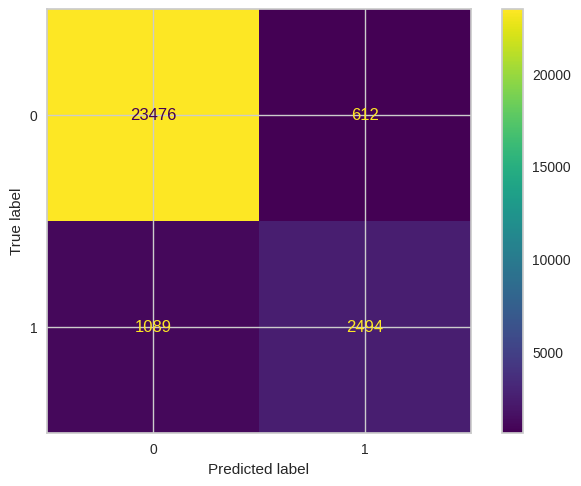

In [ ]:
import matplotlib.pyplot as plt

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

Output interpretation: It not only correctly identified 23,476 instances of short periods but also correctly identified 2,494 instances of long periods among a total of 29,571. However, it also made 1,089 incorrect predictions of a short period when in fact the duration was classified as a long period (False Negatives) and made 612 incorrect predictions of a long period when in fact the duration was classified as a short period (False Positives). When observed at the True Positive Rate (TPR) compared to the Recall among the long period cases, then it seems the model could improve. Yet among the 1,089 long-duration cases missed (i.e., False Negatives), some criterion has to be applied such that it can ensure those same cases, when applied in a practical setting, are not also missed.

### Classification report of classifier

In [ ]:
print(classification_report(train['bucket_276'], predictions['prediction_label']))


              precision    recall  f1-score   support

           0       0.96      0.97      0.97     24088
           1       0.80      0.70      0.75      3583

    accuracy                           0.94     27671
   macro avg       0.88      0.84      0.86     27671
weighted avg       0.94      0.94      0.94     27671



Output interpretation: From the results provided, we see that the model has performed admirably well, with an overall accuracy score of 0.94 on 27,671 datapoints. It has high accuracy in determining class 0. This can be seen through a precision rate of approximately 0.97, with the recall rate being similar (0.97) and an F1 score of also 0.97. These shows that the predictions of the model for the majority class is accurate and consistent. Class one has lower metrics (precision 0.80, recall 0.70, F1-score 0.75) compared to class 0, indicating that the model struggles to predict this class accurately in general. With a macro average F1 score of approximately 0.86, this shows an overall good performance irrespective of the class. With a weighted average of 0.94, we see the effective handling of the majority class by the model as well.

In [ ]:
true_labels = train['bucket_276']
predicted_labels = predictions['prediction_label']

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)

Accuracy: 0.9385277004806476


In [ ]:
data.columns

Index(['patient_id', 'patient_state', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_year',
       'region', 'division', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female',
       'married', 'divorced', 'never_married', 'widowed', 'family_size',
       'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_figure',
       'income_individual_median', 'home_ownership', 'housing_units',
       'home_value', 'rent_median', 'rent_burden', 'edu

In [ ]:
predictions.shape

(27671, 81)

In [ ]:
data.shape

(27671, 85)

##### Once the two models were trained to predict treatment_pd of either more than or fewer than 276 days, predictions from these two models (gt_pred and lt_pred) were combined into a single pred called fin_pred. This vertical concatenation generated a long list of predicted treatment durations that ranged from the shortest to the longest. When the model’s predictions were aligned with the actual outcomes in this way, the prediction that resulted was consistent and easy to evaluate because it maintained the same order and arrangement.

### Making predictions using regression models

In [ ]:
predictions=predictions.join(data[['geospatial_category_0', 'geospatial_category_1',
       'geospatial_category_2', 'geospatial_category_3',
       'geospatial_category_4']])

In [ ]:
less_than=predictions[predictions['prediction_label']==0]
greater_than=predictions[predictions['prediction_label']==1]

In [ ]:
from pycaret.regression import load_model as lm
from pycaret.regression import predict_model as pm

In [ ]:
from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()

In [ ]:
loaded_model1 = exp.load_model('model_g276_gs')

predictions1 = exp.predict_model(loaded_model1, data=greater_than[['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time',
       'veteran', 'payer_type_MEDICAID', 'payer_type_MEDICARE ADVANTAGE',
       'payer_type_UNINSURED',
       'breast_cancer_diagnosis_code_frequency_encoded',
       'metastatic_cancer_diagnosis_code_frequency_encoded',
       'metastatic_first_treatment_frequency_encoded','geospatial_category_0', 'geospatial_category_1',
       'geospatial_category_2', 'geospatial_category_3',
       'geospatial_category_4']])

Transformation Pipeline and Model Successfully Loaded


In [ ]:
predictions1

,patient_id,patient_zip3,patient_age,breast_cancer_diagnosis_year,population,density,age_median,age_under_10,age_10_to_19,age_30s,...,payer_type_UNINSURED,breast_cancer_diagnosis_code_frequency_encoded,metastatic_cancer_diagnosis_code_frequency_encoded,metastatic_first_treatment_frequency_encoded,geospatial_category_0,geospatial_category_1,geospatial_category_2,geospatial_category_3,geospatial_category_4,prediction_label
3,921275,928,50,2015,39122,2295.939453,38.200001,11.878788,13.354546,13.418181,...,0,0.102382,0.035488,0.013552,1,0,0,0,0,576.235792
6,693261,877,58,2015,1266,1.633333,53.411999,5.637931,8.968966,6.813793,...,0,0.005963,0.097792,0.058545,1,0,0,0,0,467.325533
20,895754,644,51,2015,1424,9.948571,44.261429,11.180000,12.322857,11.188571,...,0,0.102382,0.097792,0.058545,1,0,0,0,0,604.555195
28,220740,314,48,2015,21757,518.741638,36.472729,10.709091,12.027273,12.236363,...,0,0.102382,0.097792,0.000542,1,0,0,0,0,567.270261
34,559045,946,41,2015,30600,3807.060059,36.279999,9.953333,13.173333,18.633333,...,0,0.017021,0.097792,0.041487,1,0,0,0,0,556.005203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27638,773322,960,42,2015,4156,21.060810,49.943661,7.975000,10.069445,9.751389,...,0,0.003831,0.666329,0.058545,1,0,0,0,0,619.043263
27643,747386,945,50,2015,30154,976.289185,42.135803,10.753086,12.714815,13.101234,...,0,0.020238,0.097792,0.021936,1,0,0,0,0,542.403027
27650,828250,63,33,2015,7338,310.636108,44.438889,10.127778,10.983334,12.122222,...,0,0.020238,0.097792,0.164071,1,0,0,0,0,633.095853
27660,910067,221,49,2015,30611,1215.599976,38.831249,12.193750,13.456250,12.868750,...,0,0.102382,0.097792,0.058545,1,0,0,0,0,617.935695


In [ ]:
exp1 = RegressionExperiment()
loaded_model2 = exp1.load_model('model_l276_gs')

predictions2 = exp1.predict_model(loaded_model2, data=less_than[['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time',
       'veteran', 'payer_type_MEDICAID', 'payer_type_MEDICARE ADVANTAGE',
       'payer_type_UNINSURED',
       'breast_cancer_diagnosis_code_frequency_encoded',
       'metastatic_cancer_diagnosis_code_frequency_encoded',
       'metastatic_first_treatment_frequency_encoded','geospatial_category_0', 'geospatial_category_1',
       'geospatial_category_2', 'geospatial_category_3',
       'geospatial_category_4']])

Transformation Pipeline and Model Successfully Loaded


In [ ]:
predictions2

,patient_id,patient_zip3,patient_age,breast_cancer_diagnosis_year,population,density,age_median,age_under_10,age_10_to_19,age_30s,...,payer_type_UNINSURED,breast_cancer_diagnosis_code_frequency_encoded,metastatic_cancer_diagnosis_code_frequency_encoded,metastatic_first_treatment_frequency_encoded,geospatial_category_0,geospatial_category_1,geospatial_category_2,geospatial_category_3,geospatial_category_4,prediction_label
0,994155,917,46,2018,43031,2048.578369,38.852173,11.306521,12.897826,13.532609,...,0,0.047450,0.043439,0.355968,0,1,0,0,0,71.556258
1,154389,451,63,2018,7228,194.656250,41.247826,12.855319,12.789362,10.489362,...,0,0.095985,0.097792,0.355968,1,0,0,0,0,58.208777
2,387343,773,53,2018,24751,352.226776,41.371155,11.930189,12.986793,11.162264,...,0,0.028694,0.666329,0.106899,0,0,0,1,0,66.124946
4,803454,112,39,2015,71374,17326.408203,36.476315,12.986842,11.318421,17.255262,...,0,0.102382,0.026598,0.355968,1,0,0,0,0,116.225831
5,235192,462,35,2016,25675,1006.644714,35.589188,12.508108,12.600000,16.678379,...,0,0.011311,0.666329,0.150952,1,0,0,0,0,68.033904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27669,728161,653,52,2017,3385,21.780645,43.406452,10.922581,12.393548,11.241936,...,0,0.142785,0.666329,0.164071,0,0,0,1,0,47.212324
27670,203896,462,39,2015,25675,1006.644714,35.589188,12.508108,12.600000,16.678379,...,0,0.046077,0.666329,0.164071,1,0,0,0,0,67.892156
27671,740115,769,41,2017,5468,142.056000,37.573914,13.326087,16.034782,12.460870,...,0,0.046077,0.666329,0.106899,0,0,0,1,0,68.940332
27672,122759,853,53,2015,21449,595.486938,44.805798,10.692754,11.975363,10.617392,...,0,0.102382,0.666329,0.164071,1,0,0,0,0,98.390209


In [ ]:
gt_pred=predictions1['prediction_label']
lt_pred=predictions2['prediction_label']

#### Concatenating regression models vertically 

In [ ]:
fin_pred = pd.concat([gt_pred, lt_pred], axis=0)  # Concatenate vertically (axis=0)
fin_pred = fin_pred.sort_index()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming fin_pred and train['treatment_pd'] are numpy arrays or lists
# If not, you can convert them to numpy arrays using np.array()

# Calculate the mean squared error
mse = mean_squared_error(train['treatment_pd'], fin_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 140.522696509989


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming fin_pred and train['treatment_pd'] are numpy arrays or lists
# If not, you can convert them to numpy arrays using np.array()

# Calculate the mean squared error
mse = mean_squared_error(train['treatment_pd'][lt_pred.index], lt_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 104.1289673528536


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming fin_pred and train['treatment_pd'] are numpy arrays or lists
# If not, you can convert them to numpy arrays using np.array()

# Calculate the mean squared error
mse = mean_squared_error(train['treatment_pd'][gt_pred.index], gt_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 300.27597310075896


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(train['treatment_pd'], fin_pred)
mse = mean_squared_error(train['treatment_pd'], fin_pred)
rmse = np.sqrt(mse)
r2 = r2_score(train['treatment_pd'], fin_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


Mean Absolute Error (MAE): 75.06
Mean Squared Error (MSE): 19746.63
Root Mean Squared Error (RMSE): 140.52
R-squared: 0.44


Output interpretation: The model's mean absolute error (MAE)is about 75 days. On average, the model's predictions deviate from the actual treatment periods by about 75 days. The model's predictions are fairly accurate. Its mean squared error of (MSE) 19746.63 suggests that, even though the model makes fairly accurate predictions, significant variations still exist. This can happen when the model makes a few large errors and a lot of small ones. The root mean squared error (RMSE) of the model is 140.52. This reflects the fact that the model's predictions can differ quite a bit from the true values. The predicted values are just too far off. And lastly, the R-squared value of the model is 0.44. The R-squared value is the proportion of the variance in the dependent variable that is predictable from the independent variables. From the actual baseline model  with RMSE of 201 where we haven't used any feature selection, optimization or splitting of the model, the RMSE score of 140.52 for this method is a great result.

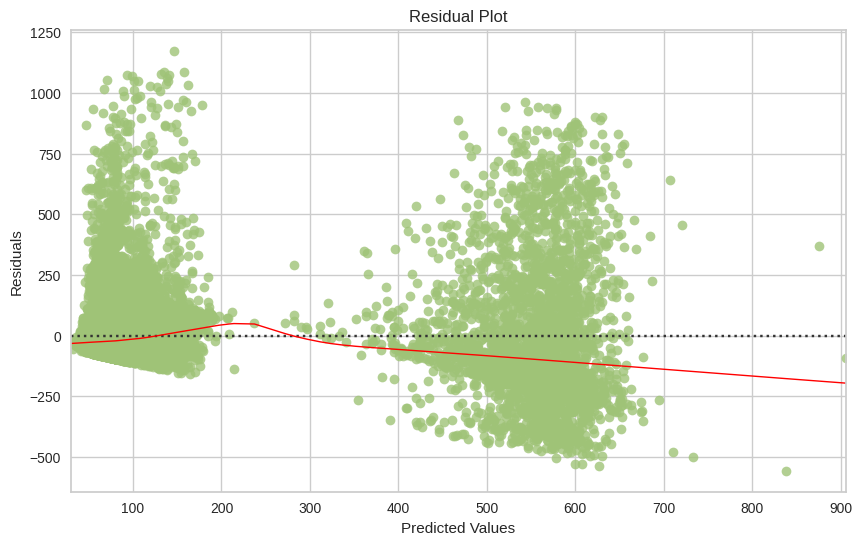

In [ ]:
import seaborn as sns
residuals = train['treatment_pd'] - fin_pred

# Plotting the residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=fin_pred, y=residuals, lowess=True, color="g", line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

Output interpretation: By displaying the predicted minus the observed treatment periods on the y-axis and the predicted treatment periods on the x-axis, the residual plot allows us to visualize at a glance the accuracy of the model predictions. Most of the residuals are formed around zero on the y-axis, indicating that the model is not, for the most part, generally over- or underestimating the values for treatment periods. However, there is an increasing spread in the appearance of the residuals the further we go out on the x-axis, implying greater amounts of variable predictions for the long-range period. The red trend line, which ought to lie almost on top of the zero line, has a slight downward slope for longer predicted treatment periods. This could mean that the model harbors a particular bias, making it quite mediocre at predicting these lengthy treatments. All sorts of residuals get scattered and muddled around the predicted values, but the clusters that form at the lower end of the graph seem to tell a positive story. In general, our findings indicate that the model's short-term predictions are pretty accurate. But its long-term predictions aren't quite there yet. They need some refinement to bring them closer to what's going to happen. This could be improving the features we're selecting, the way we're tuning the model (by changing its parameters), or both.

### Setting Up and Training a LightGBM Model Using PyCaret and  Cross-validation Results of Lgbm

The code converts the 'bucket_276' column to integer type, removes the 'treatment_pd' column, and initiates a Classification Experiment. It then configures the model setup by excluding certain geospatial categories, defining 'bucket_276' as the target, and enabling GPU usage for efficiency. After setup, the script proceeds to create and tune a LightGBM model, optimizing it for better performance.

In [ ]:
from pycaret.classification import ClassificationExperiment
train['bucket_276'] = train['bucket_276'].astype('int')
data=train.drop(['treatment_pd'], axis=1)
print(len(data.columns))
cross_class = ClassificationExperiment()
cross_class.setup(data.drop(['geospatial_category_0',
       'geospatial_category_1', 'geospatial_category_2',
       'geospatial_category_3', 'geospatial_category_4'], axis=1), target = 'bucket_276', session_id = 123, use_gpu=True)

# train model
classif_lgb = cross_class.create_model('lightgbm')

# tune model


85
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset m

,Description,Value
0,Session id,123
1,Target,bucket_276
2,Target type,Binary
3,Original data shape,"(27671, 80)"
4,Transformed data shape,"(27671, 93)"
5,Transformed train set shape,"(19369, 93)"
6,Transformed test set shape,"(8302, 93)"
7,Numeric features,75
8,Categorical features,4
9,Rows with missing values,0.3%


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9076,0.9157,0.5760,0.6636,0.6167,0.5645,0.5663
1,0.9133,0.9128,0.5817,0.6986,0.6348,0.5860,0.5892
2,0.9009,0.9224,0.5578,0.6335,0.5932,0.5370,0.5385
3,0.9133,0.9308,0.5896,0.6948,0.6379,0.5890,0.5916
4,0.9040,0.9020,0.5538,0.6526,0.5991,0.5450,0.5474
5,0.9081,0.9182,0.5139,0.6973,0.5917,0.5413,0.5493
6,0.8983,0.9122,0.5219,0.6298,0.5708,0.5137,0.5166
7,0.9138,0.9184,0.5458,0.7211,0.6213,0.5737,0.5808
8,0.9045,0.9127,0.5737,0.6486,0.6089,0.5547,0.5561


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Output interpretation: The cross-validation outcomes for the Light Gradient Boosting Machine (LGBM) classifier constantly display high performance across different folds. The classifier's mean accuracy stands at 0.8979, while its area under the receiver operating characteristic curve (AUC) amounts to 0.8879. These indicate that, in an average sense, the classifier correctly identifies around 89.8% of the instances it considers, and it effectively discriminates between the two classes defined in this problem. The level of the instance's correct classification (recall) for the positive class amounts to 41.6%. The "false positive" rate, which determines the level of "precision," is 0.6708—about two-thirds of the positive instances predicted by the LGBM classifier are indeed positive.

###  Interactive Dashboard of light gradient boosting classifier

In [ ]:
cross_class.dashboard(classif_lgb)

Note: model_output=='probability'. For LGBMClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


 96%|=================== | 7993/8302 [00:25<00:00]       

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Calibration plot of best classifer 

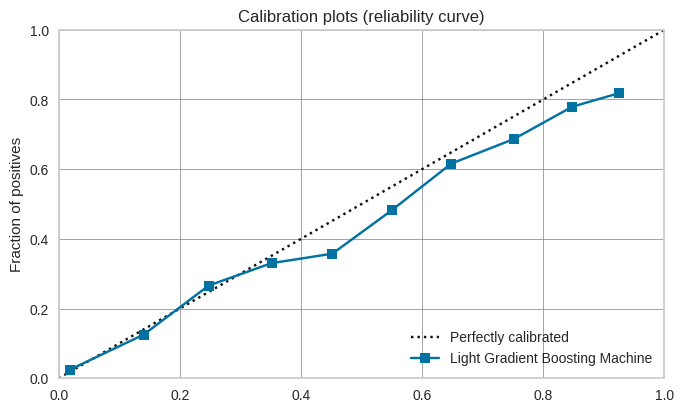

In [ ]:
cross_class.plot_model(classif_lgb, plot = 'calibration')

Output interpretation: The calibration plot (reliability curve) depicted depicts the calibration of a Light Gradient Boosting Machine (LightGBM) model to a perfectly calibrated model. The dotted line represents a perfectly calculated model consists of having predicted probabilities identical to the actual cases. A solid line with square markers illustrates the performance of LightGBM model. It shows that this model clearly approach the ideal calibration line put slightly differs from the perfect calibration in a few details. In the range of middle probability (approximately, 0.2 – 0.8), this model is tending to under-predict the fraction of positives. The model’s predictions are going along almost closely to a perfect calibration toward its high end (close to 1.0), which means that this model’s prediction is highly reliable in a high probability level.

In [ ]:
cross_class.interpret_model(classif_lgb, plot = 'reason', observation = 1)

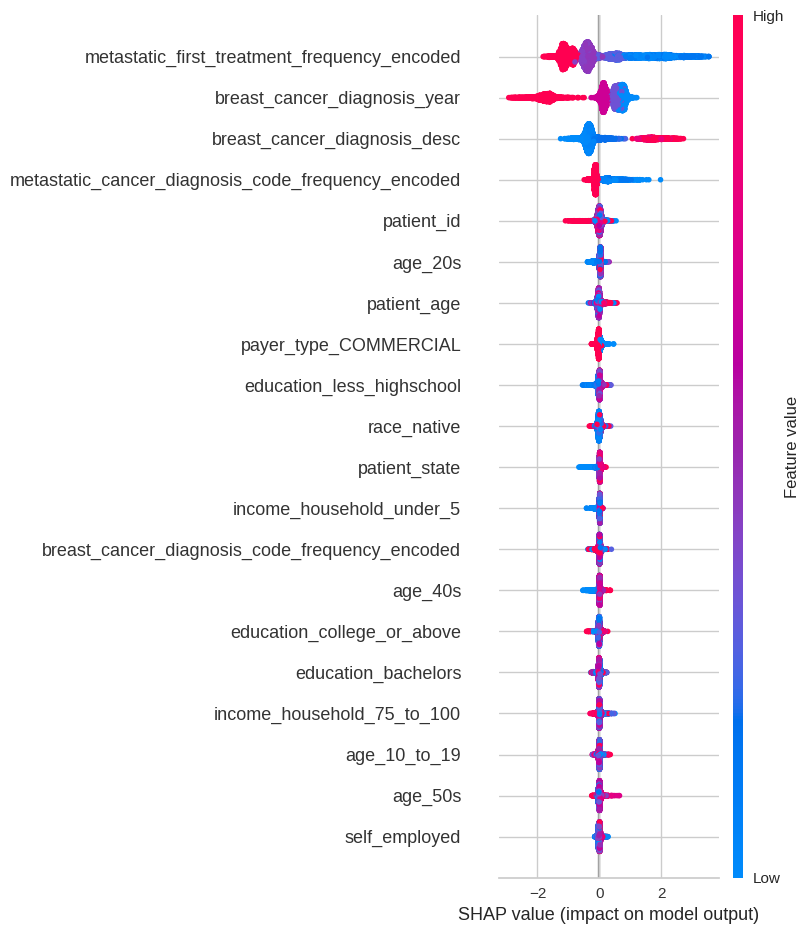

In [ ]:
cross_class.interpret_model(classif_lgb)


### Setting Up and Training a gbr Model of treatment_pd less than 276 days Using PyCaret and  Cross-validation Results of gbr

In [ ]:
exp = RegressionExperiment()
data = df_less_than_276[['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time',
       'veteran', 'payer_type_MEDICAID', 'payer_type_MEDICARE ADVANTAGE',
       'payer_type_UNINSURED',
       'breast_cancer_diagnosis_code_frequency_encoded',
       'metastatic_cancer_diagnosis_code_frequency_encoded',
       'metastatic_first_treatment_frequency_encoded','geospatial_category_0',
       'geospatial_category_1', 'geospatial_category_2',
       'geospatial_category_3', 'geospatial_category_4']]
data['treatment_pd']= df_less_than_276['treatment_pd']
exp.setup(data, target = 'treatment_pd', session_id = 123, use_gpu=True)
loaded_model1 = exp.load_model('model_l276_gs')


rg_lt_gbr = exp.create_model('gbr')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,123
1,Target,treatment_pd
2,Target type,Regression
3,Original data shape,"(24088, 62)"
4,Transformed data shape,"(24088, 62)"
5,Transformed train set shape,"(16861, 62)"
6,Transformed test set shape,"(7227, 62)"
7,Numeric features,61
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39.0152,2625.3385,51.2381,0.1874,0.9400,1.2716
1,38.7114,2577.2435,50.7666,0.1593,0.8834,1.2575
2,38.5946,2629.6881,51.2805,0.1670,0.9023,1.1187
3,39.8168,2752.8279,52.4674,0.2136,0.8891,1.0682
4,38.9463,2670.8997,51.6807,0.1967,0.8983,1.3256
5,38.6085,2591.7783,50.9095,0.1549,0.9031,1.4754
6,38.5796,2644.8833,51.4284,0.1947,0.8929,1.2875
7,38.4611,2521.3534,50.2131,0.2065,0.8626,1.4213
8,38.8729,2661.1471,51.5863,0.1899,0.8326,1.0587


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Output interpretation: The GBR (Gradient Boosting Regressor) consistently performed well in cross-validation. For all folds of the training set, it produced a mean absolute error of 38.9691 and a root mean squared error of 51.4249. Given those metrics, it registered an R² value of 0.1892, so about 19% of the variance in the lengths of washout periods.

### Residual plot of gbr 

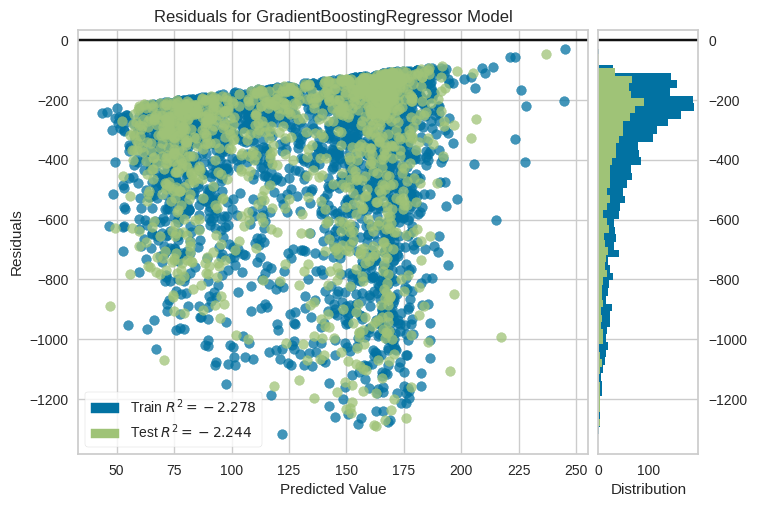

In [ ]:
exp.plot_model(rg_lt_gbr, plot = 'residuals')

Ouput interpretation: The plot shows the uneven increase in residual sums and the large number of large negative resids as the forecast increases is suggestive of heteroskedasticity and a poor fit when overall R-squared trails to nearly negative one as follows for training (-2.278) and testing (-2.244). It describes a model which has problems with the high end of the range; residuals are negatively skewed as the histogram of distribution confirms. Large negative residuals are not limited to outliers and are skewed but non-random. It tells us simply that the model does a poor job making sense of the larger points.

### Prediction error plot for gbr 

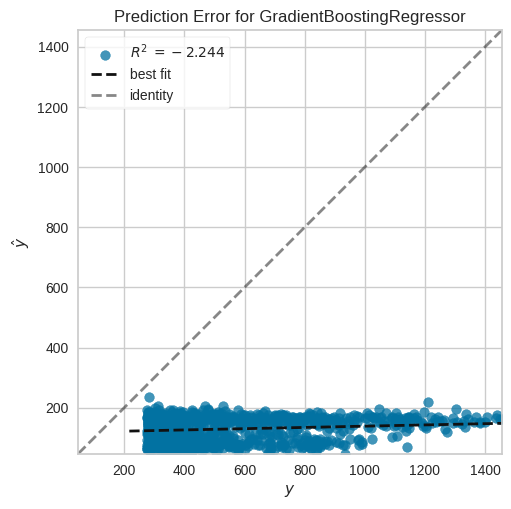

In [ ]:
exp.plot_model(rg_lt_gbr, plot = 'error')

### Setting Up and Training a gbr Model of treatment_pd less than 276 days Using PyCaret and  Cross-validation Results of gbr, and lasso

In [ ]:
exp1 = RegressionExperiment()
data = df_greater_than_276[['patient_id', 'patient_zip3', 'patient_age',
       'breast_cancer_diagnosis_year', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_30s', 'age_40s', 'age_50s',
       'age_over_80', 'male', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'home_ownership', 'home_value',
       'rent_burden', 'education_highschool', 'education_some_college',
       'education_bachelors', 'education_stem_degree',
       'labor_force_participation', 'unemployment_rate', 'self_employed',
       'farmer', 'race_asian', 'race_native', 'race_pacific', 'race_other',
       'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time',
       'veteran', 'payer_type_MEDICAID', 'payer_type_MEDICARE ADVANTAGE',
       'payer_type_UNINSURED',
       'breast_cancer_diagnosis_code_frequency_encoded',
       'metastatic_cancer_diagnosis_code_frequency_encoded',
       'metastatic_first_treatment_frequency_encoded','geospatial_category_0',
       'geospatial_category_1', 'geospatial_category_2',
       'geospatial_category_3', 'geospatial_category_4']]
data['treatment_pd']= df_greater_than_276['treatment_pd']
exp1.setup(data, target = 'treatment_pd', session_id = 123, use_gpu=True)
loaded_model1 = exp1.load_model('model_g276_gs')


rg_gt_gbr = exp1.create_model('gbr')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,123
1,Target,treatment_pd
2,Target type,Regression
3,Original data shape,"(3583, 62)"
4,Transformed data shape,"(3583, 62)"
5,Transformed train set shape,"(2508, 62)"
6,Transformed test set shape,"(1075, 62)"
7,Numeric features,61
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,203.6611,66335.2609,257.5563,0.0481,0.4416,0.4216
1,186.5369,53803.6395,231.9561,0.0058,0.4201,0.4095
2,187.8606,55657.9569,235.9194,-0.0488,0.4260,0.4158
3,206.9747,67635.0331,260.0674,0.0336,0.4562,0.4514
4,207.3630,65337.7380,255.6125,-0.0353,0.4520,0.4443
5,213.3396,75118.2860,274.0772,0.0419,0.4553,0.4214
6,208.8799,72425.0372,269.1190,0.0570,0.4368,0.3957
7,203.8756,69059.9996,262.7927,0.0273,0.4482,0.4169
8,202.1966,72905.3183,270.0098,0.0542,0.4284,0.3792


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
rg_gt_lasso = exp1.create_model('lasso')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,204.4879,65756.0090,256.4293,0.0564,0.4431,0.4263
1,183.6899,52404.9906,228.9214,0.0317,0.4123,0.3967
2,189.9751,53395.2148,231.0740,-0.0062,0.4205,0.4158
3,210.8437,67736.8998,260.2631,0.0321,0.4595,0.4587
4,204.9553,63223.9413,251.4437,-0.0018,0.4439,0.4356
5,211.3154,70323.0929,265.1850,0.1031,0.4459,0.4234
6,209.6190,72935.7814,270.0663,0.0504,0.4375,0.3937
7,206.5411,69496.3209,263.6215,0.0212,0.4479,0.4192
8,202.6529,71881.0332,268.1064,0.0675,0.4266,0.3758


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Output interpretation: The Lasso Regression model demonstrates moderate error levels, with a MAE of 203.9276 and an MSE of 65946.7206 across the tenfold cross-validation process. With an RMSE averaging 256.4023, the average deviation in the prediction from the model's fit is much less than half of the mean response value. Altogether, when taking the four assorted metric measures (mean absolute error, mean squared error, root mean squared error, and mean absolute percentage error) into account, the "lasso" exhibits steady performance. However, the low R-squared (R²) value of 0.0390 showcases the truth of the model's poor explanatory performance where it only accounts for 3.9% of the variation

### Residual plot of lasso

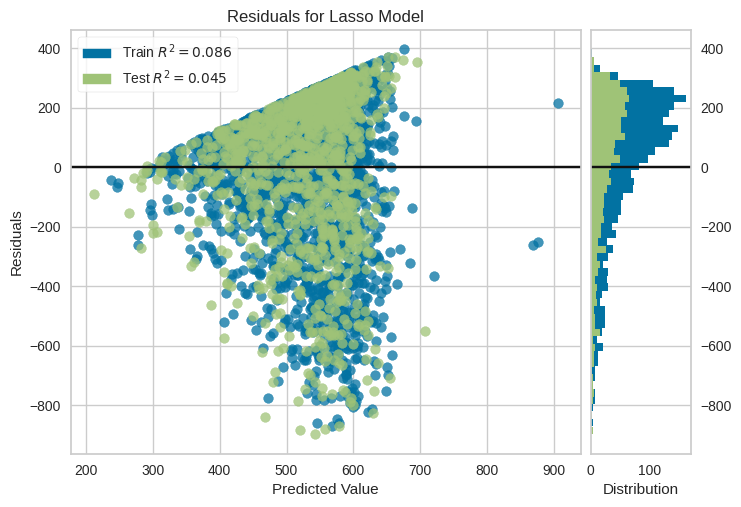

In [ ]:
exp1.plot_model(rg_gt_lasso, plot = 'residuals')

Output interpretation: The residuals plot for the Lasso model indicates that both training and testing falls very short on R-squared values (Train R² = 0.086, Test R² = 0.045). Both scores are below 0.1, demonstrating that the model explains only very little of the variance in the data. The distribution of residuals shows a spread of residuals widening as predicted values increase, which can be described as a type of pattern of heteroscedasticity called a funnel shape. A funnel shape in residuals indicates that given the increase in predicted values, the model's predictive accuracy diminishes for high numbers.

### Prediction error plot for Lasso regression

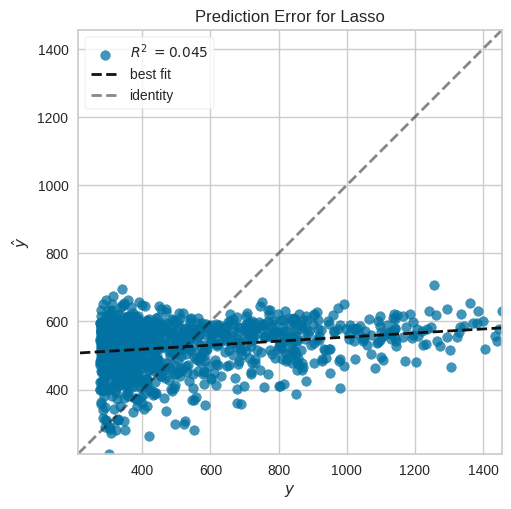

In [ ]:
exp1.plot_model(rg_gt_lasso, plot = 'error')

Output interpretation: The Lasso model’s prediction error plot presents its performance, having an R² of 0.045 meaning that it is very poor in forecasting the dependent variable. The dots are spread out about the perfect forecast line (dotted line), and the fitted regression line (solid line) lies considerably below it indicating consistent underprediction by the model. The majority of the dots are positioned under the perfect forecast line, especially for larger values of 𝑦, showing clearly that the result consistently belittle the true values while during increase